# DRL Exercise 3: Meta and Transfer Learning


Authors: Jordan Conrad-Burton and Moshe Shem Tov

## Introduction

As we have seen in previous exercises, deep reinforcement learning algorithms usually require a large number of trials, and learning a new task entails recollecting a large dataset and training from scratch.

Intuitively, knowledge gained in learning one task should help in learning new, related tasks more quickly, similarly to how humans and animals work. In this assignment, we design reinforcement learning algorithms that do exactly that. These types of algorithms are called meta- or transfer-learning algorithms.

## Section 3: Transfer Learning

In this section we will implement a simplified version of a Progressive Network. We will use the fully-trained source networks from section 1 and connect them to the untrained target network.

We will do this for two different tasks (sources -> target):

* (Acrobot, MountainCarContinuous) -> CartPole
* (CartPole, Acrobot) -> MountainCarContinuous

We wanted to be able to use the same network architecture for both problems, so we used the “trunk-head” concept from section two, where we built the main layers of the network within the trunk and changed the head part depending on if the environment was discrete or continuous. This network had two hidden layers of size 128 and used the ELU activation function. In addition, we added in two adapter layers, one for each input environment and used a gating mechanism so that the network could learn the relevance of each of the source networks’ contributions. The input from the source networks was then combined with the input from the environment and fed through the network’s hidden layers before producing an output: mean and standard deviation for the continuous environment and action probabilities for the discrete environment.

In [ ]:
!pip install gymnasium
!pip install torch torchvision

In [ ]:
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time
import sklearn
import sklearn.preprocessing
from sklearn.preprocessing import StandardScaler

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
def get_action_space_size(env):
    if isinstance(env.action_space, gym.spaces.Box):
        return env.action_space.shape[0]
    else:
        return env.action_space.n

In [ ]:
def init_weights(layer, gain=1.0):
    if isinstance(layer, nn.Linear):
        torch.nn.init.orthogonal_(layer.weight, gain=gain)
        if layer.bias is not None:
            torch.nn.init.zeros_(layer.bias)

In [ ]:
def create_scaler(env, n_samples=10000):
    states = []
    for _ in range(n_samples):
        s = env.observation_space.sample()
        states.append(s)
    states = np.array(states)

    scaler = sklearn.preprocessing.StandardScaler()
    scaler.fit(states)
    return scaler

In [ ]:
def scale_state(state, scaler):
    scaled = scaler.transform(state.reshape(1, -1))
    # return as 1D
    return scaled[0]

In [ ]:
def pad_state(state, max_input_size):
    padded_state = np.zeros(max_input_size)
    padded_state[: len(state)] = state

    return padded_state

In [ ]:
def mask_action(action_probs, act_space):
    masked_probs = action_probs.clone()
    masked_probs[act_space:] = 0
    masked_probs /= masked_probs.sum()

    return masked_probs

In [ ]:
def check_rewards_average(rewards_per_episode, episode, rolling_avg_rewards, target_average):
    rewards_last_100 = rewards_per_episode[-100:]
    rolling_avg = np.mean(rewards_last_100)
    rolling_avg_rewards.append(rolling_avg)

    if rolling_avg >= target_average:
        print(f"Agent reached optimal performance with an average reward of {target_average} over 100 episodes at episode {episode + 1}")

    return rolling_avg

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sm = nn.Softmax(dim=-1)

    def forward(self, x):
        hidden = self.relu(self.fc1(x))
        out = self.sm(self.fc2(hidden))
        return out

    def extract_features(self, x):
        return self.relu(self.fc1(x))

In [ ]:
class PolicyNetworkContinuous(nn.Module):
    def __init__(self, input_size, output_size, hidden_size1=128, hidden_size2=128):
        super(PolicyNetworkContinuous, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.elu = nn.ELU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)

        self.mu_layer = nn.Linear(hidden_size2, output_size)
        self.log_std = nn.Parameter(torch.zeros(output_size))

        self.apply(init_weights)

    def forward(self, x):
        x = self.elu(self.fc1(x))
        x = self.elu(self.fc2(x))

        mu = self.mu_layer(x)
        log_std = self.log_std.clamp(-2, 1)
        std = torch.exp(log_std)
        return mu, std

    def extract_features(self, x):
        h1 = self.fc1(x)
        h2 = self.fc2(self.elu(h1))
        return [h1, h2]

In [ ]:
class ValueNetwork(nn.Module):
    def __init__(self, input_size, hidden_size=128):
        super(ValueNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        return self.fc(x)

In [ ]:
class ValueNetworkContinuous(nn.Module):
    def __init__(self, input_size, hidden_size1=400, hidden_size2=400):
        super(ValueNetworkContinuous, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ELU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ELU(),
            nn.Linear(hidden_size2, 1)
        )
        self.apply(init_weights)

    def forward(self, x):
        return self.fc(x)

In [ ]:
class TargetNetworkSharedTrunk(nn.Module):
    def __init__(self, input_size, hidden_size=128, adapter_dim=64, adapter_hidden=128):
        super(TargetNetworkSharedTrunk, self).__init__()

        # multi-layer adapters
        self.adapter1 = nn.Sequential(
            nn.Linear(128, adapter_hidden),
            nn.ELU(),
            nn.Linear(adapter_hidden, adapter_dim),
            nn.ELU()
        )
        self.adapter2 = nn.Sequential(
            nn.Linear(128, adapter_hidden),
            nn.ELU(),
            nn.Linear(adapter_hidden, adapter_dim),
            nn.ELU()
        )

        # gating parameters to help the network understand relevance
        self.gate1 = nn.Parameter(torch.zeros(1))
        self.gate2 = nn.Parameter(torch.zeros(1))

        self.fc1 = nn.Linear(input_size + 2 * adapter_dim, 256)
        self.fc2 = nn.Linear(256, hidden_size)
        self.activation = nn.ELU()

    def forward(self, x, env1_feats, env2_feats):

        env1_adapted = self.adapter1(env1_feats)  # shape [batch, adapter_dim]
        env2_adapted = self.adapter2(env2_feats)

        g1 = torch.sigmoid(self.gate1)
        g2 = torch.sigmoid(self.gate2)
        env1_adapted = g1 * env1_adapted
        env2_adapted = g2 * env2_adapted

        combined_input = torch.cat([x, env1_adapted, env2_adapted], dim=-1)
        z = self.activation(self.fc1(combined_input))
        out = self.activation(self.fc2(z))  # shape [batch, hidden_size]
        return out

In [ ]:
class TargetTrunkMulti(nn.Module):
    def __init__(self, input_size, target_hidden_dims,
                 adapter_hidden=128, source_feature_dim=128):

        super(TargetTrunkMulti, self).__init__()

        self.num_target_layers = len(target_hidden_dims)

        self.target_layers = nn.ModuleList()
        prev_dim = input_size
        for h_dim in target_hidden_dims:
            self.target_layers.append(nn.Linear(prev_dim, h_dim))
            prev_dim = h_dim

        # for each target layer, create an adapter for each source network.
        self.adapters_source1 = nn.ModuleList()
        self.adapters_source2 = nn.ModuleList()
        for h_dim in target_hidden_dims:
            self.adapters_source1.append(nn.Sequential(
                nn.Linear(source_feature_dim, adapter_hidden),
                nn.ELU(),
                nn.Linear(adapter_hidden, h_dim),
                nn.ELU()
            ))
            self.adapters_source2.append(nn.Sequential(
                nn.Linear(source_feature_dim, adapter_hidden),
                nn.ELU(),
                nn.Linear(adapter_hidden, h_dim),
                nn.ELU()
            ))

        # gating parameters for each target layer and source.
        self.gates_source1 = nn.ParameterList([nn.Parameter(torch.zeros(1)) for _ in range(self.num_target_layers)])
        self.gates_source2 = nn.ParameterList([nn.Parameter(torch.zeros(1)) for _ in range(self.num_target_layers)])

        self.activation = nn.ELU()

    def forward(self, x, env1_features, env2_features):

        if not isinstance(env1_features, (list, tuple)):
            env1_features = [env1_features]
        if not isinstance(env2_features, (list, tuple)):
            env2_features = [env2_features]

        out = x
        num_target_layers = self.num_target_layers

        for i, layer in enumerate(self.target_layers):
            target_act = self.activation(layer(out))

            connection_index = -(num_target_layers - i)

            lateral_sum = 0
            count = 0

            # for source1: if it has enough layers, use its corresponding hidden feature.
            if len(env1_features) >= abs(connection_index):
                src1 = env1_features[connection_index]
                adapted_src1 = self.adapters_source1[i](src1)
                gate1 = torch.sigmoid(self.gates_source1[i])
                lateral_sum += gate1 * adapted_src1
                count += 1

            # for source2
            if len(env2_features) >= abs(connection_index):
                src2 = env2_features[connection_index]
                adapted_src2 = self.adapters_source2[i](src2)
                gate2 = torch.sigmoid(self.gates_source2[i])
                lateral_sum += gate2 * adapted_src2
                count += 1

            # if at least one lateral connection is present, average and combine.
            if count > 0:
                lateral_avg = lateral_sum / count
                out = target_act + lateral_avg
            else:
                out = target_act
        return out

In [ ]:
class TargetNetworkDiscreteHeadPolicy(nn.Module):
    def __init__(self, trunk_output_dim, output_size):
        super(TargetNetworkDiscreteHeadPolicy, self).__init__()
        self.fc = nn.Linear(trunk_output_dim, output_size)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        logits = self.fc(x)
        out = self.softmax(logits)
        return out

In [ ]:
class TargetNetworkContinuousHeadPolicy(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(TargetNetworkContinuousHeadPolicy, self).__init__()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.activation = nn.ELU()

        self.mu = nn.Linear(hidden_size, output_size)
        self.log_std = nn.Parameter(torch.zeros(output_size))

    def forward(self, x):
        x = self.activation(self.fc2(x))
        mu_val = self.mu(x)
        log_std_val = self.log_std.clamp(-2, 1)
        return mu_val, log_std_val

In [ ]:
class TargetNetworkContinuous(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=128):
        super().__init__()
        self.trunk = TargetNetworkSharedTrunk(input_size, hidden_size)
        self.continuous_head = TargetNetworkContinuousHeadPolicy(hidden_size, output_size)

    def forward(self, x, env1_feats, env2_feats):
        features = self.trunk(x, env1_feats, env2_feats)
        mu, log_std = self.continuous_head(features)
        std = torch.exp(log_std)
        return mu, std

In [ ]:
class TargetNetworkDiscreteMulti(nn.Module):
    def __init__(self, input_size, target_hidden_dims, output_size,
                 adapter_hidden=128, source_feature_dim=128):

        super(TargetNetworkDiscreteMulti, self).__init__()
        self.trunk = TargetTrunkMulti(input_size, target_hidden_dims,
                                           adapter_hidden=adapter_hidden,
                                           source_feature_dim=source_feature_dim)
        self.head = TargetNetworkDiscreteHeadPolicy(target_hidden_dims[-1], output_size)

    def forward(self, x, env1_feats, env2_feats):
        trunk_out = self.trunk(x, env1_feats, env2_feats)
        out = self.head(trunk_out)
        return out

In [ ]:
def actor_critic(env, policy_network, value_network, policy_optimizer, value_optimizer, act_space_size, max_input_size,
                 num_episodes=1000, gamma=0.99, convergence_window=100, convergence_threshold=195, optimal_performance_threshold=475):
    policy_network.train()
    value_network.train()

    rewards_per_episode = []
    rolling_avg_rewards = []
    policy_losses = []
    value_losses = []
    convergence = False

    start_time = time.time()

    for episode in range(num_episodes):
        state = env.reset()

        if isinstance(env.action_space, gym.spaces.Box):
            scaler = create_scaler(env)
            state = scale_state(state, scaler)

        total_reward = 0
        policy_episode_loss = 0.0
        value_episode_loss = 0.0

        done = False
        while not done:
            padded_state = pad_state(state, max_input_size)
            state_tensor = torch.tensor(padded_state, dtype=torch.float32)

            action_probs = policy_network(state_tensor)

            # continuous action space
            if isinstance(env.action_space, gym.spaces.Box):
                mu, std = action_probs
                action_dist = torch.distributions.Normal(mu, std)
                action = action_dist.sample()
                action = torch.clamp(action, min=-1.0, max=1.0)

                log_prob = action_dist.log_prob(action)
                next_state, reward, done, _ = env.step(action.detach().numpy())
                next_state = scale_state(next_state, scaler)

            # discrete action space
            else:
                masked_probs = mask_action(action_probs, act_space_size)
                action_dist = torch.distributions.Categorical(masked_probs)
                action = action_dist.sample()
                log_prob = action_dist.log_prob(action)
                next_state, reward, done, _ = env.step(action.item())

            value = value_network(state_tensor)

            padded_next_state = pad_state(next_state, max_input_size)
            next_state_tensor = torch.tensor(padded_next_state, dtype=torch.float32)

            # compute TD error
            with torch.no_grad():
                if not done:
                    next_value = value_network(next_state_tensor)
                else:
                    next_value = torch.tensor(0.0)

            td_error = reward + gamma * next_value - value  # δ_t = r + γV(s') - V(s)

            # update actor
            policy_loss = (-log_prob * td_error.detach()).sum()  # advantage = δ_t
            policy_optimizer.zero_grad()
            policy_loss.backward()
            policy_optimizer.step()

            # update critic
            value_loss = td_error.pow(2)
            value_optimizer.zero_grad()
            value_loss.backward()
            value_optimizer.step()

            policy_episode_loss += policy_loss.item()
            value_episode_loss += value_loss.item()

            state = next_state
            total_reward += reward

        rewards_per_episode.append(total_reward)
        rolling_avg_reward = check_rewards_average(rewards_per_episode, episode, rolling_avg_rewards, optimal_performance_threshold)
        policy_losses.append(policy_episode_loss)
        value_losses.append(value_episode_loss)
        print(f"Episode {episode + 1}, Episode Reward: {total_reward}, Rolling Avg Reward: {rolling_avg_reward}")

        # check for stable convergence
        if len(rolling_avg_rewards) >= convergence_window and not convergence:
            if np.all(np.array(rolling_avg_rewards[-convergence_window:]) >= convergence_threshold):
                convergence_episode = episode
                print(f"Convergence reached at episode {episode + 1}")
                convergence = True

        if rolling_avg_reward >= optimal_performance_threshold and convergence:
            break

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total training time: {elapsed_time:.2f} seconds")

    return rewards_per_episode, policy_losses, value_losses, rolling_avg_rewards, policy_network, value_network

In [ ]:
def actor_critic_progressive_target_training(env, policy_network, value_network, policy_optimizer, value_optimizer, act_space_size, max_input_size,
                                             policy_net_source1, policy_net_source2, num_episodes=1000, gamma=0.99, beta=0.01, convergence_window=100,
                                             convergence_threshold=195, optimal_performance_threshold=475):
    policy_network.train()
    value_network.train()

    rewards_per_episode = []
    rolling_avg_rewards = []
    policy_losses = []
    value_losses = []
    convergence = False

    start_time = time.time()

    if isinstance(env.action_space, gym.spaces.Box):
        scaler = create_scaler(env)

    for episode in range(num_episodes):
        state = env.reset()

        if isinstance(env.action_space, gym.spaces.Box):
            state = scale_state(state, scaler)

        total_reward = 0
        policy_episode_loss = 0.0
        value_episode_loss = 0.0

        done = False
        while not done:
            padded_state = pad_state(state, max_input_size)
            state_tensor = torch.tensor(padded_state, dtype=torch.float32)

            env1_feats = policy_net_source1.extract_features(state_tensor)
            env2_feats = policy_net_source2.extract_features(state_tensor)

            action_probs = policy_network(state_tensor, env1_feats, env2_feats)

            # continuous action space
            if isinstance(env.action_space, gym.spaces.Box):
                mu, std = action_probs
                action_dist = torch.distributions.Normal(mu, std)
                action = action_dist.sample()
                action = torch.clamp(action, min=-1.0, max=1.0)

                log_prob = action_dist.log_prob(action)
                entropy = action_dist.entropy().sum(dim=-1)

                next_state, reward, done, _ = env.step(action.detach().numpy())
                next_state = scale_state(next_state, scaler)

            # discrete action space
            else:
                masked_probs = mask_action(action_probs, act_space_size)
                action_dist = torch.distributions.Categorical(masked_probs)
                action = action_dist.sample()
                log_prob = action_dist.log_prob(action)
                entropy = action_dist.entropy()

                next_state, reward, done, _ = env.step(action.item())

            value = value_network(state_tensor)

            padded_next_state = pad_state(next_state, max_input_size)
            next_state_tensor = torch.tensor(padded_next_state, dtype=torch.float32)

            # compute TD error
            with torch.no_grad():
                if not done:
                    next_value = value_network(next_state_tensor)
                else:
                    next_value = torch.tensor(0.0)

            td_error = reward + gamma * next_value - value  # δ_t = r + γV(s') - V(s)

            # update actor
            policy_loss = (-log_prob * td_error.detach()).sum() - beta*entropy  # advantage = δ_t
            policy_optimizer.zero_grad()
            policy_loss.backward()
            policy_optimizer.step()

            # update critic
            value_loss = td_error.pow(2)
            value_optimizer.zero_grad()
            value_loss.backward()
            value_optimizer.step()

            policy_episode_loss += policy_loss.item()
            value_episode_loss += value_loss.item()

            state = next_state
            total_reward += reward

        rewards_per_episode.append(total_reward)
        rolling_avg_reward = check_rewards_average(rewards_per_episode, episode, rolling_avg_rewards, optimal_performance_threshold)
        policy_losses.append(policy_episode_loss)
        value_losses.append(value_episode_loss)
        print(f"Episode {episode + 1}, Episode Reward: {total_reward}, Rolling Avg Reward: {rolling_avg_reward}")

        # check for stable convergence
        if len(rolling_avg_rewards) >= convergence_window and not convergence:
            if np.all(np.array(rolling_avg_rewards[-convergence_window:]) >= convergence_threshold):
                convergence_episode = episode
                print(f"Convergence reached at episode {episode + 1}")
                convergence = True

        if rolling_avg_reward >= optimal_performance_threshold and convergence:
            break

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total training time: {elapsed_time:.2f} seconds")

    return rewards_per_episode, policy_losses, value_losses, rolling_avg_rewards

In [ ]:
envs = {
    "CartPole-v1": gym.make("CartPole-v1"),
    "Acrobot-v1": gym.make("Acrobot-v1"),
    "MountainCarContinuous-v0": gym.make("MountainCarContinuous-v0")
}

env_targets = {
    "CartPole-v1": {"optimal": 475, "convergence": 195, "lr_p": 0.0002171250228971598, "lr_v": 0.0006, "gamma": 0.9915614564438548},
    "Acrobot-v1": {"optimal": -100, "convergence": -200, "lr_p": 0.0006403723092688441, "lr_v": 0.0008903908181162374, "gamma": 0.9936670420538545},
    "MountainCarContinuous-v0": {"optimal": 90, "convergence": 50, "lr_p": 3.7549879519576414e-05, "lr_v": 0.0005749550762716619, "gamma": 0.9971441494660566}
}

max_input_size = max(env.observation_space.shape[0] for env in envs.values())
max_output_size = max(env.action_space.shape[0] if isinstance(env.action_space, gym.spaces.Box) else env.action_space.n for env in envs.values())

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


### {Acrobot, CartPole} --> MountainCarContinuous

This was the first problem we implemented. We took the networks from the first section that were trained on the Acrobot and CartPole environments and applied them to the MountainCarContinuous (MCC) environment using the progressive network architecture described above. We struggled from the beginning to make this architecture work, as the network would get stuck with reward values of -99 (specifically the rewards would reach -99.8999999999986 and stay there) each episode.

Since we had already successfully trained the MCC environment both by itself and using fine-tuning, we decided to try to base our network architecture on the architectures that had worked for us before. This worked partially. We saw that we were getting episodes with rewards above 80 or even 90, indicating that the agent was learning how to get the reward. However, after about episode 40, once again the rewards dropped and stayed around the -99 mark, indicating that the agent was unlearning somehow. To solve this problem, we ended up adding in an entropy factor to the policy loss in order to try to prevent the collapse of the policy that we were seeing to -99 by encouraging exploration. After adding in this factor, we dropped the learning rate of the policy to $5\times10^{-6}$ since we were seeing unstable results before the collapse. All other hyperparameters stayed the same as in section 1. We used a value of 0.01 for beta, the hyperparameter that we defined for the entropy factor.

The combination of these two resulted in successful transfer learning of the Acrobot and CartPole policy networks to the MCC environment. We did not transfer the value networks since these were more specific to each environment and thus not relevant to transfer from one to the other.


In [ ]:
# train on Acrobot
source1_name = "Acrobot-v1"
env = gym.make(source1_name)

lr_p = env_targets[source1_name]["lr_p"]
lr_v = env_targets[source1_name]["lr_v"]
gamma = env_targets[source1_name]["gamma"]

target_optimal = env_targets[source1_name]["optimal"]
target_convergence = env_targets[source1_name]["convergence"]
action_space_size = get_action_space_size(env)

policy_net_source1 = PolicyNetwork(max_input_size, max_output_size)
value_net_source1 = ValueNetwork(max_input_size)

policy_optimizer = optim.Adam(policy_net_source1.parameters(), lr=lr_p)
value_optimizer = optim.Adam(value_net_source1.parameters(), lr=lr_v)

print(f"Training on {source1_name}")

rewards_per_episode, policy_losses, value_losses, rolling_avg_rewards, policy_net_source1, value_net_source1 = actor_critic(
    env, policy_net_source1, value_net_source1, policy_optimizer, value_optimizer, action_space_size,
    max_input_size, num_episodes=2000, gamma=gamma, convergence_window=100,
    convergence_threshold=target_convergence, optimal_performance_threshold=target_optimal)

In [ ]:
torch.save(policy_net_source1.state_dict(), "/content/drive/MyDrive/acrobot_policy.pth")
print("Saved Acrobot policy network.")

In [ ]:
# train on CartPole
source2_name = "CartPole-v1"
env = gym.make(source2_name)

lr_p = env_targets[source2_name]["lr_p"]
lr_v = env_targets[source2_name]["lr_v"]
gamma = env_targets[source2_name]["gamma"]

target_optimal = env_targets[source2_name]["optimal"]
target_convergence = env_targets[source2_name]["convergence"]
action_space_size = get_action_space_size(env)

policy_net_source2 = PolicyNetwork(max_input_size, max_output_size)
value_net_source2 = ValueNetwork(max_input_size)

policy_optimizer = optim.Adam(policy_net_source2.parameters(), lr=lr_p)
value_optimizer = optim.Adam(value_net_source2.parameters(), lr=lr_v)

print(f"Training on {source2_name}")

rewards_per_episode, policy_losses, value_losses, rolling_avg_rewards, policy_net_source2, value_net_source2 = actor_critic(
    env, policy_net_source2, value_net_source2, policy_optimizer, value_optimizer, action_space_size,
    max_input_size, num_episodes=3000, gamma=gamma, convergence_window=100,
    convergence_threshold=target_convergence, optimal_performance_threshold=target_optimal)

In [ ]:
torch.save(policy_net_source2.state_dict(), "/content/drive/MyDrive/cartpole_policy.pth")
print("Saved CartPole policy network.")

In [ ]:
policy_net_source1 = PolicyNetwork(input_size=max_input_size, output_size=max_output_size)
policy_net_source1.load_state_dict(torch.load("/content/drive/MyDrive/acrobot_policy.pth"))

policy_net_source2 = PolicyNetwork(input_size=max_input_size, output_size=max_output_size)
policy_net_source2.load_state_dict(torch.load("/content/drive/MyDrive/cartpole_policy.pth"))

for param in policy_net_source1.parameters():
    param.requires_grad = False
for param in policy_net_source2.parameters():
    param.requires_grad = False

policy_net_source1.eval()
policy_net_source2.eval()

In [ ]:
# train on target: MountainCarContinuous
target_name = "MountainCarContinuous-v0"
env = gym.make(target_name)

# lr_p = env_targets[target_name]["lr_p"]
lr_p = 5e-6
lr_v = env_targets[target_name]["lr_v"]
gamma = env_targets[target_name]["gamma"]
beta = 0.01

target_optimal = env_targets[target_name]["optimal"]
target_convergence = env_targets[target_name]["convergence"]
action_space_size = get_action_space_size(env)

policy_net_target = TargetNetworkContinuous(max_input_size, max_output_size)
value_net_target = ValueNetworkContinuous(max_input_size)

policy_optimizer = optim.Adam(policy_net_target.parameters(), lr=lr_p)
value_optimizer = optim.Adam(value_net_target.parameters(), lr=lr_v)

print(f"Training on {target_name}")

rewards_per_episode, policy_losses, value_losses, rolling_avg_rewards = actor_critic_progressive_target_training(
    env, policy_net_target, value_net_target, policy_optimizer, value_optimizer, action_space_size,
    max_input_size, policy_net_source1, policy_net_source2, num_episodes=2000, gamma=gamma, beta=beta, convergence_window=100,
    convergence_threshold=target_convergence, optimal_performance_threshold=target_optimal)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Training on MountainCarContinuous-v0


/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1, Episode Reward: 53.23846772230483, Rolling Avg Reward: 53.23846772230483
Episode 2, Episode Reward: -54.287265766021854, Rolling Avg Reward: -0.5243990218585104
Episode 3, Episode Reward: -52.47456891070049, Rolling Avg Reward: -17.84112231813917
Episode 4, Episode Reward: -51.78160523070288, Rolling Avg Reward: -26.326243046280098
Episode 5, Episode Reward: -51.6234048694937, Rolling Avg Reward: -31.38567541092282
Episode 6, Episode Reward: -52.44367168879271, Rolling Avg Reward: -34.895341457234466
Episode 7, Episode Reward: -52.33993661928365, Rolling Avg Reward: -37.38742648038435
Episode 8, Episode Reward: -50.36572757569407, Rolling Avg Reward: -39.00971411729806
Episode 9, Episode Reward: -49.28983013032032, Rolling Avg Reward: -40.151949229856086
Episode 10, Episode Reward: -54.48220498017859, Rolling Avg Reward: -41.58497480488834
Episode 11, Episode Reward: -53.774348613062465, Rolling Avg Reward: -42.69309969654053
Episode 12, Episode Reward: -52.87124311658888, R

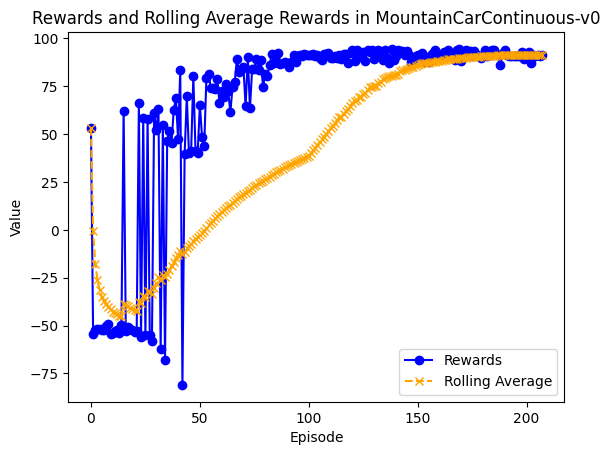

In [ ]:
# Plot: rewards and avg rewards in each training step

plt.plot(rewards_per_episode, label="Rewards", color="blue", linestyle='-', marker='o')
plt.plot(rolling_avg_rewards, label="Rolling Average", color="orange", linestyle='--', marker='x')
plt.title(f"Rewards and Rolling Average Rewards in {target_name}")
plt.xlabel("Episode")
plt.ylabel("Value")
plt.legend()
plt.show()

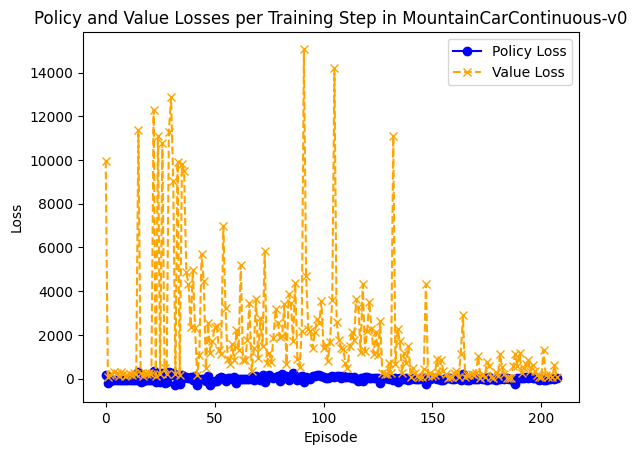

In [ ]:
# Plot: rewards and avg rewards in each training step

plt.plot(policy_losses, label="Policy Loss", color="blue", linestyle='-', marker='o')
plt.plot(value_losses, label="Value Loss", color="orange", linestyle='--', marker='x')
plt.title(f"Policy and Value Losses per Training Step in {target_name}")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.legend()
plt.show()

### {Acrobot, MountainCarContinuous} --> CartPole

In this section, we created a different trunk that could take networks with more than one hidden layer as input (and possibly different numbers of layers) and combine them as shown in the exercise. Similarly to the previous case, we used adapters in between layers to help combine the source networks’ layers and the target layers and kept the entropy factor. In addition, in order to simplify things, we increased the size of the hidden layers in the continuous policy network that we had previously trained the MCC environment on from 40 to 128. We retrained the MCC environment on this new policy network and used it as one of the sources for this transfer learning task.

When running this network, we did not experience the collapse we did in the previous task, but we did need to perform hyperparameter tuning for the new network. After running many trials of random search and getting final averages of around 9 or 10 for a reward (instead of the optimal goal of 475), we decided to try switching the value network to the one we used in the continuous case with the hidden layer size of 400 since this helped the agent learn much better in the MCC environment. While there were still some trials in which we got final averages of around 9 or 10, most of the trials had larger final averages. We also continued to see the instability in the network’s learning that we saw in the previous sections, so we played with dropping the range of the policy network’s learning rate when hyperparameter tuning. Even after many trials of hyperparameter tuning and finding suitable hyperparameters in which the network both converged and reached optimal performance, when we would train the agent in the CartPole environment again with these hyperparameters, it would fail to converge, ending with a final average of around 9. So, we took these parameters found in the tuning and simply tried dropping the policy network’s learning rate until the network was able to train stably, reaching convergence at episode 809 and optimal performance at episode 1383.

The hyperparameters we used were:
* Policy network learning rate: 0.000001900109305931221
* Value network learning rate: 0.0003918148726890883
* Gamma: 0.9988403974878086
* Beta: 0.016186454513244523


In [ ]:
# train on MountainCarContinuous
source2_name = "MountainCarContinuous-v0"
env = gym.make(source2_name)

lr_p = env_targets[source2_name]["lr_p"]
lr_v = env_targets[source2_name]["lr_v"]
gamma = env_targets[source2_name]["gamma"]

target_optimal = env_targets[source2_name]["optimal"]
target_convergence = env_targets[source2_name]["convergence"]
action_space_size = get_action_space_size(env)

policy_net_source2 = PolicyNetworkContinuous(max_input_size, max_output_size)
value_net_source2 = ValueNetworkContinuous(max_input_size)

policy_optimizer = optim.Adam(policy_net_source2.parameters(), lr=lr_p)
value_optimizer = optim.Adam(value_net_source2.parameters(), lr=lr_v)

print(f"Training on {source2_name}")

rewards_per_episode, policy_losses, value_losses, rolling_avg_rewards, policy_net_source2, value_net_source2 = actor_critic(
    env, policy_net_source2, value_net_source2, policy_optimizer, value_optimizer, action_space_size,
    max_input_size, num_episodes=2000, gamma=gamma, convergence_window=100,
    convergence_threshold=target_convergence, optimal_performance_threshold=target_optimal)

In [ ]:
torch.save(policy_net_source2.state_dict(), "/content/drive/MyDrive/mcc_policy.pth")
print("Saved Mountain Car Continuous policy network.")

In [ ]:
policy_net_source1 = PolicyNetwork(input_size=max_input_size, output_size=max_output_size)
policy_net_source1.load_state_dict(torch.load("/content/drive/MyDrive/acrobot_policy.pth"))

policy_net_source2 = PolicyNetworkContinuous(input_size=max_input_size, output_size=max_output_size)
policy_net_source2.load_state_dict(torch.load("/content/drive/MyDrive/mcc_policy.pth"))

for param in policy_net_source1.parameters():
    param.requires_grad = False
for param in policy_net_source2.parameters():
    param.requires_grad = False

policy_net_source1.eval()
policy_net_source2.eval()

In [ ]:
# train on target: CartPole
target_name = "CartPole-v1"
env = gym.make(target_name)

lr_p = 0.000001900109305931221
lr_v = 0.0003918148726890883
gamma = 0.9988403974878086
beta = 0.016186454513244523

target_optimal = env_targets[target_name]["optimal"]
target_convergence = env_targets[target_name]["convergence"]
action_space_size = get_action_space_size(env)

target_hidden_dims = [256,128]
policy_net_target = TargetNetworkDiscreteMulti(max_input_size, target_hidden_dims=target_hidden_dims, output_size=max_output_size)
value_net_target = ValueNetworkContinuous(max_input_size)

policy_optimizer = optim.Adam(policy_net_target.parameters(), lr=lr_p)
value_optimizer = optim.Adam(value_net_target.parameters(), lr=lr_v)

print(f"Training on {target_name}")

rewards_per_episode, policy_losses, value_losses, rolling_avg_rewards = actor_critic_progressive_target_training(
    env, policy_net_target, value_net_target, policy_optimizer, value_optimizer, action_space_size,
    max_input_size, policy_net_source1, policy_net_source2, num_episodes=2000, gamma=gamma, beta=beta, convergence_window=100,
    convergence_threshold=target_convergence, optimal_performance_threshold=target_optimal)

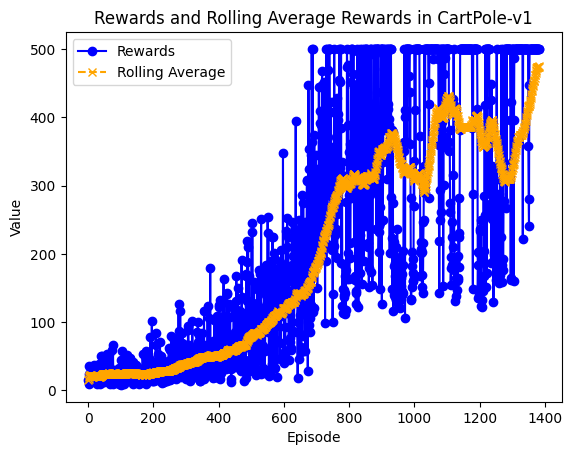

In [ ]:
# Plot: rewards and avg rewards in each training step

plt.plot(rewards_per_episode, label="Rewards", color="blue", linestyle='-', marker='o')
plt.plot(rolling_avg_rewards, label="Rolling Average", color="orange", linestyle='--', marker='x')
plt.title(f"Rewards and Rolling Average Rewards in {target_name}")
plt.xlabel("Episode")
plt.ylabel("Value")
plt.legend()
plt.show()

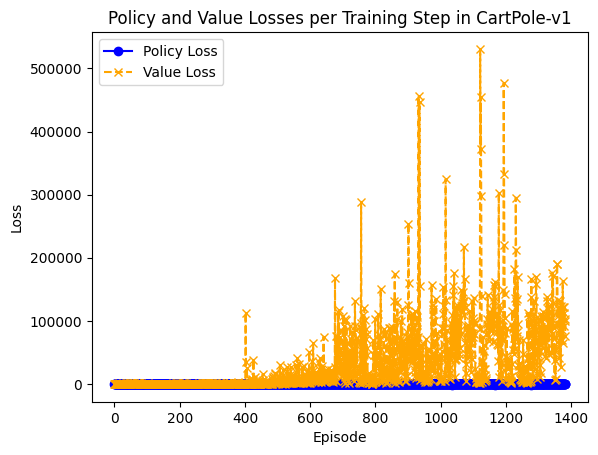

In [ ]:
# Plot: rewards and avg rewards in each training step

plt.plot(policy_losses, label="Policy Loss", color="blue", linestyle='-', marker='o')
plt.plot(value_losses, label="Value Loss", color="orange", linestyle='--', marker='x')
plt.title(f"Policy and Value Losses per Training Step in {target_name}")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Hyperparameter Tuning

In [ ]:
def random_hyperparameters():
    return {
        'gamma': random.uniform(0.99, 0.999),
        'beta': random.uniform(0.0005, 0.02),
        'learning_rate_policy': random.uniform(1e-6, 5e-4),
        'learning_rate_value': random.uniform(5e-5, 1e-3),
    }

In [ ]:
def actor_critic_progressive_target_tuning(env, policy_network, value_network, policy_optimizer, value_optimizer, act_space_size, max_input_size,
                                             policy_net_source1, policy_net_source2, num_episodes=1000, gamma=0.99, beta=0.01, convergence_window=100,
                                             convergence_threshold=195, optimal_performance_threshold=475):
    policy_network.train()
    value_network.train()

    rewards_per_episode = []
    rolling_avg_rewards = []
    policy_losses = []
    value_losses = []
    convergence = False

    start_time = time.time()

    if isinstance(env.action_space, gym.spaces.Box):
        scaler = create_scaler(env)

    for episode in range(num_episodes):
        state = env.reset()

        if isinstance(env.action_space, gym.spaces.Box):
            state = scale_state(state, scaler)

        total_reward = 0
        policy_episode_loss = 0.0
        value_episode_loss = 0.0

        done = False
        while not done:
            padded_state = pad_state(state, max_input_size)
            state_tensor = torch.tensor(padded_state, dtype=torch.float32)

            env1_feats = policy_net_source1.extract_features(state_tensor)
            env2_feats = policy_net_source2.extract_features(state_tensor)

            action_probs = policy_network(state_tensor, env1_feats, env2_feats)

            # continuous action space
            if isinstance(env.action_space, gym.spaces.Box):
                mu, std = action_probs
                action_dist = torch.distributions.Normal(mu, std)
                action = action_dist.sample()
                action = torch.clamp(action, min=-1.0, max=1.0)

                log_prob = action_dist.log_prob(action)
                entropy = action_dist.entropy().sum(dim=-1)

                next_state, reward, done, _ = env.step(action.detach().numpy())
                next_state = scale_state(next_state, scaler)

            # discrete action space
            else:
                masked_probs = mask_action(action_probs, act_space_size)
                action_dist = torch.distributions.Categorical(masked_probs)
                action = action_dist.sample()
                log_prob = action_dist.log_prob(action)
                entropy = action_dist.entropy()

                next_state, reward, done, _ = env.step(action.item())

            value = value_network(state_tensor)

            padded_next_state = pad_state(next_state, max_input_size)
            next_state_tensor = torch.tensor(padded_next_state, dtype=torch.float32)

            # compute TD error
            with torch.no_grad():
                if not done:
                    next_value = value_network(next_state_tensor)
                else:
                    next_value = torch.tensor(0.0)

            td_error = reward + gamma * next_value - value  # δ_t = r + γV(s') - V(s)

            # update actor
            policy_loss = (-log_prob * td_error.detach()).sum() - beta*entropy  # advantage = δ_t
            policy_optimizer.zero_grad()
            policy_loss.backward()
            policy_optimizer.step()

            # update critic
            value_loss = td_error.pow(2)
            value_optimizer.zero_grad()
            value_loss.backward()
            value_optimizer.step()

            policy_episode_loss += policy_loss.item()
            value_episode_loss += value_loss.item()

            state = next_state
            total_reward += reward

        rewards_per_episode.append(total_reward)
        rolling_avg_reward = check_rewards_average(rewards_per_episode, episode, rolling_avg_rewards, optimal_performance_threshold)
        policy_losses.append(policy_episode_loss)
        value_losses.append(value_episode_loss)
        print(f"Episode {episode + 1}, Episode Reward: {total_reward}, Rolling Avg Reward: {rolling_avg_reward}")

        # check for stable convergence
        if len(rolling_avg_rewards) >= convergence_window and not convergence:
            if np.all(np.array(rolling_avg_rewards[-convergence_window:]) >= convergence_threshold):
                convergence_episode = episode
                print(f"Convergence reached at episode {episode + 1}")
                convergence = True

        if rolling_avg_reward >= optimal_performance_threshold and convergence:
            break

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total training time: {elapsed_time:.2f} seconds")

    return np.mean(rewards_per_episode[-100:])

In [ ]:
env = gym.make("CartPole-v1")

best_hyperparams = None
best_performance = -float('inf')
num_trials = 20
target_optimal = env_targets["CartPole-v1"]["optimal"]
target_convergence = env_targets["CartPole-v1"]["convergence"]
action_space_size = get_action_space_size(env)


for trial in range(num_trials):
    params = random_hyperparameters()

    target_hidden_dims = [256,128]
    policy_network = TargetNetworkDiscreteMulti(max_input_size, target_hidden_dims=target_hidden_dims, output_size=max_output_size)
    value_network = ValueNetworkContinuous(max_input_size)

    policy_optimizer = optim.Adam(policy_network.parameters(), lr=params['learning_rate_policy'])
    value_optimizer = optim.Adam(value_network.parameters(), lr=params['learning_rate_value'])

    print(f"Trial {trial + 1}: {params}")

    avg_reward = actor_critic_progressive_target_tuning(env, policy_network, value_network, policy_optimizer, value_optimizer, action_space_size,
                                                        max_input_size, policy_net_source1, policy_net_source2, num_episodes=2000, gamma=params['gamma'],
                                                        beta=params['beta'], convergence_window=100, convergence_threshold=target_convergence,
                                                        optimal_performance_threshold=target_optimal)

    print(f"Avg Reward: {avg_reward}")

    if avg_reward > best_performance:
        best_performance = avg_reward
        best_hyperparams = params

print("\nBest Hyperparameters for CartPole:")
print(best_hyperparams)
print(f"Best Performance for CartPole: {best_performance}")

## Discussion




**MountainCarContinuous**

In the first section, we trained the agent on this environment with no previous knowledge. With the additional layer in the policy network and the increased size of the value network, the algorithm reached convergence at episode 100 and optimal performance at episode 138.

In the second section, we first pretrained the agent on the CartPole environment and then fine-tuned the network on the MCC environment. In this case, we used the smaller networks that we had used for the discrete environments and the algorithm reached convergence at episode 266 and optimal performance at episode 234.

In this last section, we used transfer learning from both the Acrobot and CartPole environments with the progressive network described above. The algorithm reached convergence at episode 208 and optimal performance at episode 174.

Looking just at the number of episodes and the time it took to complete the training successfully, the training in the first section performed the best. However, the transfer learning network did perform better than the fine-tuning since it both converged and reached optimal performance earlier, and it did not require that the network be trained beforehand, increasing the runtime.

With this environment, we struggled with adapting the discrete networks to a continuous one, and with the agent learning effectively in a more complex environment with the same networks as we used in the simpler environments. Increasing the size of the value network layers was one of the most significant changes we made that allowed the agent to effectively learn, converge, and reach optimal performance in a short period of time. We believe that experimenting with the structure of the networks even further for all three versions of the training could allow for even better performance.

We also looked at the graphs of the rewards and losses to determine how well the network was learning.

**Plots of Rewards for MCC**

*Section 1*

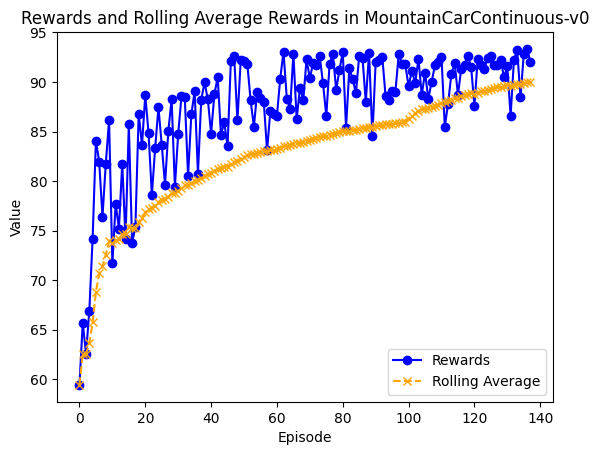

*Section 2*

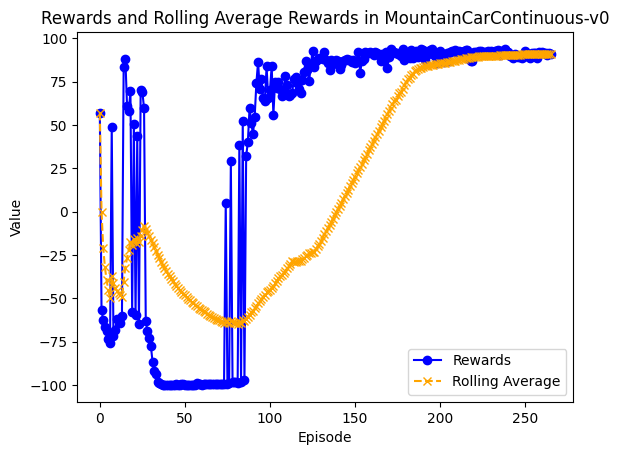

*Section 3*

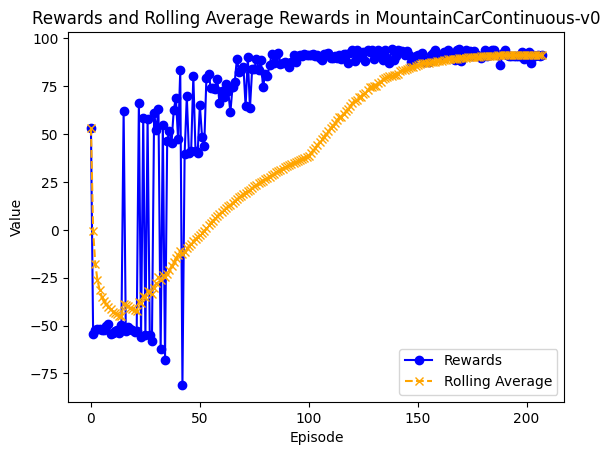

We have the graphs of the rewards over time of the agent training in the MCC environment. In the first section, training alone, we can see that the reward value has fluctuations within a value of 10 as it converges, and the average only increases with no dipping beforehand. This is as opposed to the other two cases where we see that there are very large fluctuations in the beginning, reaching from around -99 or -75 before jumping up to stay in the 80-90 range before convergence and optimal performance.


**Plots of Losses for MCC**

*Section 1*

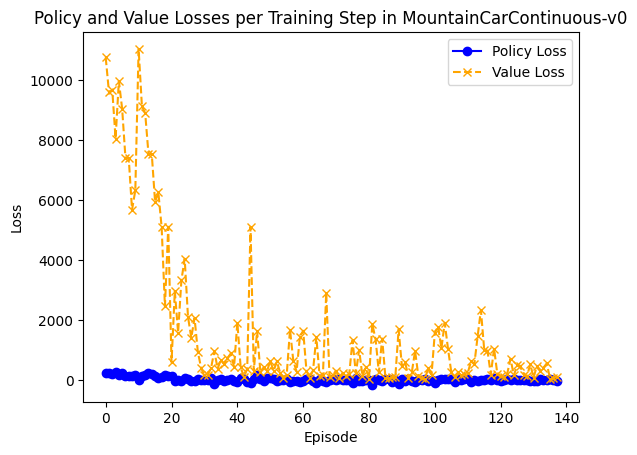

*Section 2*

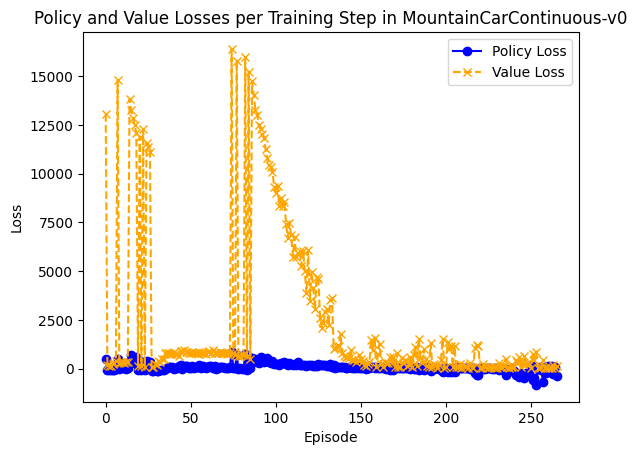

*Section 3*

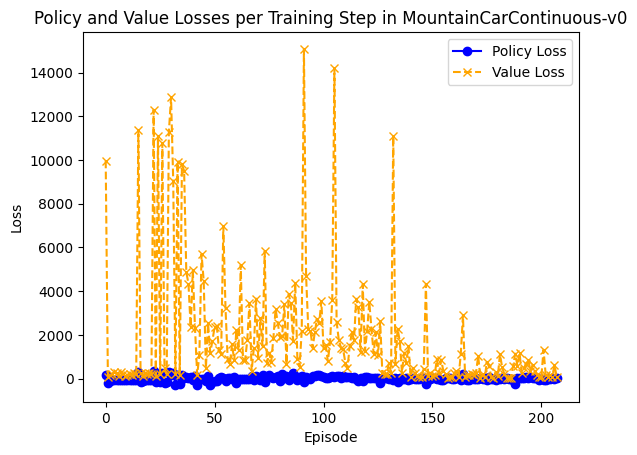

These graphs show the losses of the policy and value networks over time. In the first case, the value loss starts out very high and then more or less converges between 0 and 2000 by episode 50. In the second case, we have very large fluctuations in the value loss, and two spikes reaching up to losses of over 15,000 before drastically decreasing and converging very close to 0. In the third case, the value loss fluctuates widely for most of the training until the end when it converges close to 0.

Looking at the trends of the rewards and losses as well as the runtime for convergence and optimal performance, we would have to conclude that the original training with the larger network performed the best out of the three. The size and number of layers of the policy and value networks had a significant effect on the outcome of the agent training on this environment, and so the network architecture for the fine-tuning and transfer learning would be the main thing we would experiment with in order to get better results and faster convergence times. In addition, it is possible that choosing different environments, not Acrobot or CartPole, to use for pretraining or input to the transfer learning network could make a significant difference. If the environment(s) that the agent learns from is(are) closer to that of the MCC environment, the training could be even more effective and faster since the agent already will have a better base to learn from.


**CartPole**

In the first section, we trained the agent on this environment with no previous knowledge, and the algorithm reached convergence at episode 1319 and optimal performance at episode 1803.

In the second section, we performed fine-tuning by pretraining the network on the Acrobot environment and then fine-tuning on the CartPole environment. The algorithm reached convergence at episode 1609 and optimal performance at episode 1606. While it took longer for it to converge than in the first section, it did reach optimal performance earlier.

In the third section, we performed transfer learning from the Acrobot and MCC environments with the progressive network described above. The algorithm reached convergence at episode 809 and optimal performance at episode 1383.

In general, in this environment, we saw that the reward achieved by the agent often fluctuated, and it was actually this environment in which it took the agent the longest to converge. Even after heavy parameter tuning, sometimes the network would not converge or reach optimal performance within 2000 episodes. It could be that the agent could benefit from changing the architecture of the policy and value networks similarly to the case in the MCC environment.

We looked at the graphs of the rewards and losses to determine how well the network was learning.


**Plots of Rewards for CartPole**

*Section 1*

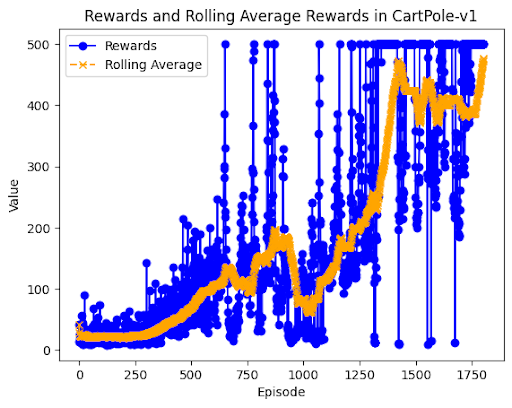

*Section 2*

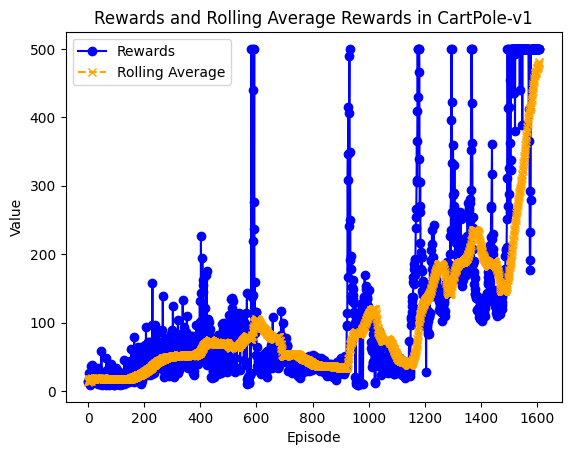

*Section 3*

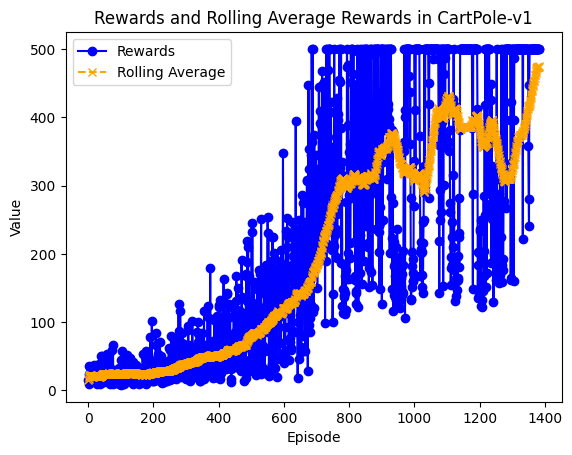

In the first case, we can see that the agent reached the maximum reward for the first time after about 650 episodes, but the rewards continued to fluctuate even when the network reached optimal performance with a rolling average of 475. In the second case, we see that the agent reached the maximum reward of 500 a bit earlier than in the first case, but the average reward remained quite low until the end. In the third case, it took until about episode 650 for the agent to reach the maximum reward, similarly to the first case but after that, it was more consistent in reaching the maximum reward of 500, creating a steadier increase in the average reward without the large fluctuations of the previous two cases.  

**Plots of Losses for CartPole**

*Section 1*

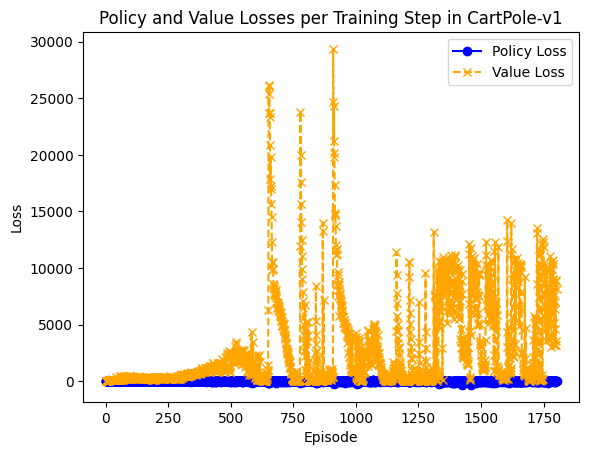

*Section 2*

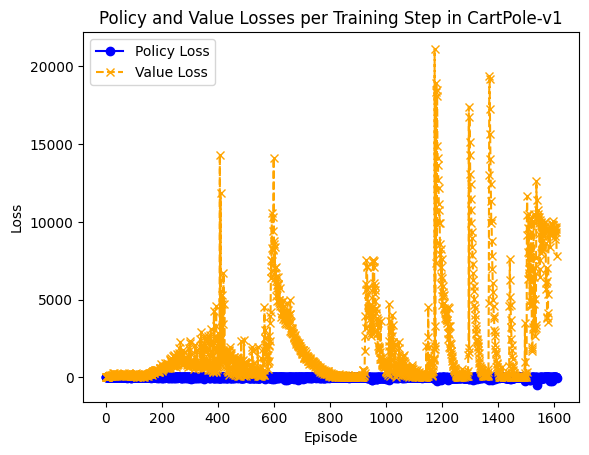

*Section 3*

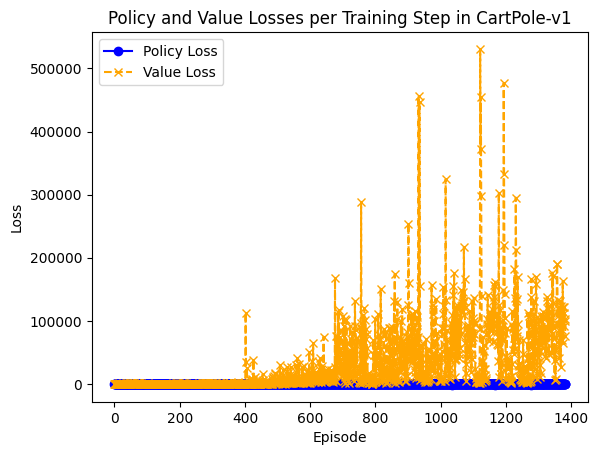

In the first case, we see that the value loss fluctuates greatly, reaching around 30,000 at its highest. Even when the network converged and reached optimal performance, we can see that the value loss did not drop to 0 and was still fluctuating. This together with the fluctuations we can see in the rewards graph from the first case, we can see that there is instability in the network. Similarly, in the second case, we see large fluctuations in the value loss which did not resolve and drop to 0 once the network reached convergence and optimal performance. In the third case, the loss for the value network was very low even though the rewards were also very low. It did reach the highest loss seen by the three different cases with a loss of over 50,000, but towards the end, it looks as if it is dropping and converging.

For the CartPole environment, it was actually the transfer learning network that we feel worked the best. In the other two cases, no matter the parameter tuning, the network was very unstable and could reach convergence before 2,000 episodes but in some runs (with the same networks and parameters) it wouldn’t reach convergence or optimal performance within 2,000 episodes. In the transfer learning network, we reached convergence at episode 809, almost 1,000 episodes before the other two cases reached convergence.

However, because of the increased stability of the policy network (lower learning rate), the training time of the progressive network was about five times longer than the training times of the other cases. This is because more episodes had higher scores from the beginning (and thus longer times), slowly increasing the average, instead of having some episodes with lower scores (shorter times) and then some with higher scores (and longer times). This could also be because training the progressive network is heavier and has more parameters to update and calculations to perform than the previous simpler networks.

Overall, we felt that there were many other possibilities to experiment with in terms of policy and value network structures, activation functions, and how exactly we can combine the two source network parameters to effectively train the target network. In addition, outside of the scope of this exercise, there are possibilities of choosing different environments to pretrain networks on, some of which might be better suited for certain problems. In general, we felt that there were a lot of different variables that can be explored in these kinds of problems, especially more thorough parameter tuning and network architectures that can greatly affect the performance of these networks both with and without transfer learning. We felt that the transfer learning did improve the performance of the agent in the CartPole environment, but the increased stability of the network made training times longer. We also felt that the transfer learning did perform well in the MountainCarContinuous environment but in terms of convergence times and general stability, the original network performed the best, which leads us to our previous statement that this could be because of the differences in the network architectures as well as a simplistic implementation of the progressive network.
